In [2]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS

from scipy.optimize import curve_fit

code_id = "0860 - 2 - Retrieval on Session-Basis"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

saved_dir = join(loc, "Retrieval Results")
dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis") 
mkdir(saved_dir)
pass

        D:\Data\FinalResults\Dsp\0860 - 2 - Retrieval on Session-Basis is already existed!
        D:\Data\FinalResults\Dsp\0860 - 2 - Retrieval on Session-Basis\Retrieval Results is already existed!


In [ ]:
from scipy.optimize import curve_fit

# logistic function
def logistic(t, k, t0):
    return 1 / (1 + np.exp(-k * (t - t0)))

def gaussian_kernel(x, sigma=1.0):
    """Gaussian kernel function."""
    y = np.exp(-0.5 * (x / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    return y/np.sum(y)

def hidden_state_proportion(
    mouse: int,
    maze_type: int,
    rt: int = 0
):
    if exists(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl")):
        with open(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl"), 'rb') as f:
            return pickle.load(f)
    else:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
            
        hidden_state_traj = res['raw_hidden_state_traj']
        session_traj = res['raw_session_traj']
        route_traj = res['raw_route_traj']
        nodes_traj = res['raw_nodes_traj']
        father_nodes_traj = S2F[nodes_traj-1]
        lap_traj = res['raw_lap_traj']
        time_traj = res['raw_time_traj']
        dt = np.zeros_like(time_traj, np.float64)
        
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]))
        for i in range(len(beg)):
            dt[beg[i]:end[i]] = np.diff(time_traj[beg[i]:end[i]], prepend=time_traj[beg[i]])
        
        if rt == 0:
            state_sum = np.zeros((144, 7*4))
            time_sum = np.zeros((144, 7*4))
            for s in range(7):
                n_lap = np.unique(lap_traj[(route_traj == 0) & (session_traj == s)])
                
                division = np.concatenate([np.arange(0, n_lap.shape[0], int(n_lap.shape[0]/4)+1), [n_lap.shape[0]]])
                for i in range(division.shape[0]-1):
                    for b in CP_DSPs[maze_type][0]:
                        idx = np.where(
                            (np.isin(lap_traj, n_lap[division[i]:division[i+1]])) &
                            (session_traj == s) &
                            (route_traj == 0) & 
                            (father_nodes_traj == b)
                        )[0]
                        
                        if idx.shape[0] < 1:
                            continue                
                    
                        state_sum[b-1, s*4 + i] = np.sum((1-hidden_state_traj[idx]) * dt[idx])
                        time_sum[b-1, s*4 + i] = np.sum(dt[idx])
            
            prop = np.zeros((144, 7*4))
            for j in range(prop.shape[1]):
                
                prop[CP_DSPs[maze_type][0]-1, j] = (
                    np.convolve(state_sum[CP_DSPs[maze_type][0]-1, j], np.ones(7), mode='same') /
                    np.convolve(time_sum[CP_DSPs[maze_type][0]-1, j], np.ones(7), mode='same')
                )
            
            with open(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl"), 'wb') as f:
                pickle.dump(prop, f)
            
            return prop
        else:
            state_sum = np.zeros((144, 7))
            time_sum = np.zeros((144, 7))
            for s in range(7):
                for b in CP_DSPs[maze_type][rt]:
                    idx = np.where(
                        (route_traj == rt) &
                        (session_traj == s) & 
                        (father_nodes_traj == b)
                    )[0]
                    
                    if idx.shape[0] < 1:
                        continue
                    
                    state_sum[b-1, s] = np.sum((1-hidden_state_traj[idx]) * dt[idx])
                    time_sum[b-1, s] = np.sum(dt[idx])
                    
            prop = np.zeros((144, 7))
            for j in range(prop.shape[1]):
                prop[CP_DSPs[maze_type][rt]-1, j] = (
                    np.convolve(state_sum[CP_DSPs[maze_type][rt]-1, j], np.ones(7), mode='same') /
                    np.convolve(time_sum[CP_DSPs[maze_type][rt]-1, j], np.ones(7), mode='same')
                )
                
            if rt == 3:
                prop *= np.nan
            if rt == 6:
                convert_session = np.where(session_convertor[mouse] >= 0)[0][0]
                prop[:, convert_session:] = np.nan
                
            with open(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl"), 'wb') as f:
                pickle.dump(prop, f)
            return prop

maze_type = 1
for mouse in [10212, 10224, 10227, 10232]:
    for r in range(7):
        hidden_state_proportion(mouse, maze_type, r)
prop_r0 = hidden_state_proportion(10232, maze_type, 0)
percentage = 50

# Compute CI-95
top_line = np.nanmean(prop_r0[CP_DSPs[maze_type][0]-1, :], axis=1)
#mean_val = top_line
#sem_val = scipy.stats.sem(prop_r0[CP_DSPs[maze_type][0]-1, :], axis=1, nan_policy='omit')
#ci95 = sem_val * scipy.stats.t.ppf(0.975, prop_r0.shape[1]-1)
#bottom_line = mean_val - ci95
#top_line = mean_val + ci95

bottom_line = np.nanmean(prop_r0[CP_DSPs[maze_type][0]-1, :], axis=1) * percentage / 100
#bottom_line_whole = np.ones(144)
#bottom_line_whole[CP_DSPs[maze_type][0]-1] = bottom_line

prop_r5 = hidden_state_proportion(10232, maze_type, 5)
fig = plt.figure(figsize=(3, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(prop_r0.shape[1]):
    ax.plot(
        np.arange(1, 112),
        prop_r0[CP_DSPs[maze_type][0]-1, i],
        color='grey',
        lw=0.2
    )
ax.plot(
    np.arange(1, 112),
    np.nanmean(prop_r0[CP_DSPs[maze_type][0]-1, :], axis=1),
    color='k',
    lw=1
),
ax.fill_between(
    np.arange(1, 112),
    top_line,
    bottom_line,
    color='k',
    edgecolor=None,
    alpha=0.2
)
#idx = np.where(prop_r5[CP_DSPs[maze_type][5]-1, 0] - bottom_line_whole[CP_DSPs[maze_type][5]-1] >= 0)[0]
ax.plot(
    np.arange(1, 112)[-CP_DSPs[maze_type][5].shape[0]:],
    prop_r5[CP_DSPs[maze_type][5]-1, 0],
    color=DSPPalette[5],
    lw=1
)
ax.axvline(np.arange(1, 112)[-CP_DSPs[maze_type][5].shape[0]:][idx[0]], color='k', lw=0.5, ls='--')
ax.set_ylim(0, 1.02)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, "Hidden State Retrieval [Example].png"), dpi=600)
plt.savefig(join(loc, "Hidden State Retrieval [Example].svg"), dpi=600)
plt.show()


NameError: name 'exists' is not defined

[-0.87521282 -0.83780349 -0.84804355 -0.66937532 -0.69146009 -0.67986045
 -0.66197059 -0.67275921 -0.66832508 -0.64369791 -0.61276272 -0.61158432
 -0.64076215 -0.64443625 -0.60992867 -0.53740988 -0.46693218 -0.43461148
 -0.43196147 -0.37221234 -0.25151262 -0.188668   -0.21878    -0.29206421
 -0.34287558 -0.3058115  -0.20805329 -0.1382242  -0.09974848 -0.08860709
 -0.10557201 -0.11201466 -0.09340497 -0.07427605 -0.03911702  0.00768009
  0.00596047 -0.03955803 -0.0740741  -0.04187754  0.01842816  0.03005569
 -0.00742498 -0.03979664 -0.04521318 -0.06016138 -0.08241472 -0.05797784
 -0.00169562  0.03969171  0.0246114  -0.01874444 -0.03666863 -0.04234986
 -0.06271512 -0.08063817 -0.0501511  -0.01711553  0.01114534  0.03661487
  0.02902062 -0.03618471 -0.14426051 -0.19941883 -0.14174297 -0.08548263
 -0.1386246  -0.21279452]
[35 36 40 41 49 50 58 59 60]


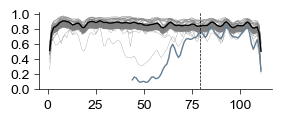

In [ ]:
def gaussian_kernel(x, sigma=1.0):
    """Gaussian kernel function."""
    y = np.exp(-0.5 * (x / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    return y/np.sum(y)

def get_session_wise_neural_retrieval(mouse: int, maze_type: int, rt: int = 0):
    if exists(join(saved_dir, f" {mouse}_neural_R{rt+1}.pkl")):
        with open(join(saved_dir, f"{mouse}_neural_R{rt+1}.pkl"), 'rb') as f:
            corr = pickle.load(f)

        gkernel = gaussian_kernel(np.arange(-3, 4, 1), sigma=1)
        for i in range(corr.shape[1]):
            corr[CP_DSPs[maze_type][rt]-1, i] = np.nan_to_num(corr[CP_DSPs[maze_type][rt]-1, i], nan=0)
            corr[CP_DSPs[maze_type][rt]-1, i] = np.convolve(
                corr[CP_DSPs[maze_type][rt]-1, i], gkernel, mode='same'
            )
        return corr
    else:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        print(f"{mouse} R{rt+1}")
        if rt == 0:
            corr = np.zeros((144, 7*2))
            for s in tqdm(range(7)):
                with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                    trace = pickle.load(f)
            
                r0_map_avg = np.mean(np.stack([
                    trace[f'node {n}']['old_map_clear'] for n in [0, 4, 5, 9]
                ], axis=2), axis=2)
            
                for i, n in enumerate([0, 4, 5, 9]):
                    r0_map = trace[f'node {n}']['old_map_clear']
                    for b in CP_DSPs[maze_type][0]:
                        corr[b-1, s*4 + i] = np.corrcoef(
                            r0_map[:, b-1], r0_map_avg[:, b-1]
                        )[0, 1]
            
        else:
            corr = np.zeros((144, 7))
            for s in tqdm(range(7)):
                with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                    trace = pickle.load(f)

                r0_map_avg = np.mean(np.stack([
                    trace[f'node {n}']['old_map_clear'] for n in [0, 4, 5, 9]
                ], axis=2), axis=2)

                nodes_convertor = np.array([0, 1, 2, 3, 6, 7, 8])
                for i, b in enumerate(CP_DSP[rt]):
                    rt_map = trace[f'node {nodes_convertor[rt]}']['old_map_clear']
                    corr[b-1, s] = np.corrcoef(
                        rt_map[:, b-1], r0_map_avg[:, b-1]
                    )[0, 1]
                
        with open(join(saved_dir, f"{mouse}_neural_R{rt+1}.pkl"), 'wb') as f:
            pickle.dump(corr, f)
    
        for i in range(corr.shape[1]):
            corr[CP_DSP[rt]-1, i] = np.nan_to_num(corr[CP_DSP[rt]-1, i], nan=0)
            corr[CP_DSP[rt]-1, i] = np.convolve(
                corr[CP_DSP[rt]-1, i], np.ones(7)/7, mode='same'
            ) 
        return corr

for mouse in [10212, 10224, 10227, 10232]:
    for r in range(7):
        get_session_wise_neural_retrieval(mouse, r)

corr_r0 = get_session_wise_neural_retrieval(10232, 0)
percentage = 90
top_line = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1)
bottom_line = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1) * percentage / 100
bottom_line_whole = np.ones(144)
bottom_line_whole[CP_DSP[0]-1] = bottom_line

corr_r5 = get_session_wise_neural_retrieval(10232, 5)

fig = plt.figure(figsize=(3, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(corr_r0.shape[1]):
    ax.plot(
        np.arange(1, 112),
        corr_r0[CP_DSP[0]-1, i],
        color='grey',
        lw=0.2
    )
ax.plot(
    np.arange(1, 112),
    np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1),
    color='k',
    lw=1
),
ax.fill_between(
    np.arange(1, 112),
    top_line,
    bottom_line,
    color='k',
    edgecolor=None,
    alpha=0.5
)
idx = np.where(corr_r5[CP_DSP[5]-1, 0] - bottom_line_whole[CP_DSP[5]-1] >= 0)[0]
print(corr_r5[CP_DSP[5]-1, 0] - bottom_line_whole[CP_DSP[5]-1])
print(idx)
ax.plot(
    np.arange(1, 112)[-CP_DSP[5].shape[0]:],
    corr_r5[CP_DSP[5]-1, 0],
    color=DSPPalette[5],
    lw=1
)
ax.axvline(np.arange(1, 112)[-CP_DSP[5].shape[0]:][idx[0]], color='k', lw=0.5, ls='--')
ax.set_ylim(0, 1.02)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, "Neuronal Retrieval [Example].png"), dpi=600)
plt.savefig(join(loc, "Neuronal Retrieval [Example].svg"), dpi=600)
plt.show()

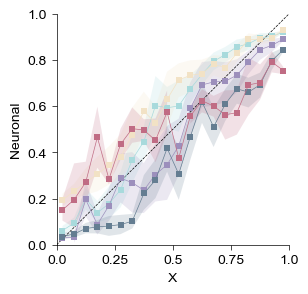

In [4]:
if exists(join(figdata, f"{code_id} [Behav Neural Corr].pkl")) == False:
    BNCorr = {
        'MiceID': [],
        'Route': [],
        'Session': [],
        'Behavior': [],
        'Neuronal': []
    }

    for mouse in [10212, 10224, 10227, 10232]:
        corr_r0 = get_session_wise_neural_retrieval(mouse, 0)
        top_line = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1)
        top_line_whole = np.ones(144)
        top_line_whole[CP_DSP[0]-1] = top_line
        
        prop_r0 = hidden_state_proportion(mouse, 0)
        top_line_behav = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1)
        top_line_whole_behav = np.ones(144)
        top_line_whole_behav[CP_DSP[0]-1] = top_line
        for r in tqdm([1, 2, 4, 5, 6]):
            prop_r = hidden_state_proportion(mouse, r)
            corr_r = get_session_wise_neural_retrieval(mouse, r)
            for i in range(7):
                if r == 6 and session_convertor[mouse][i] >= 0:
                    continue
                BNCorr['Behavior'].append(prop_r[CP_DSP[r]-1, i] / top_line_whole_behav[CP_DSP[r]-1])
                BNCorr['Neuronal'].append(corr_r[CP_DSP[r]-1, i] / top_line_whole[CP_DSP[r]-1])
                BNCorr['Route'].append(np.repeat(r, CP_DSP[r].shape[0]))
                BNCorr['Session'].append(np.repeat(i, CP_DSP[r].shape[0]))
                BNCorr['MiceID'].append(np.repeat(mouse, CP_DSP[r].shape[0]))
    
    for k in BNCorr.keys():
        BNCorr[k] = np.concatenate(BNCorr[k])
    
    with open(join(figdata, f"{code_id} [Behav Neural Corr].pkl"), 'wb') as f:
        pickle.dump(BNCorr, f)
    
    BNCorrD = pd.DataFrame(BNCorr)
    BNCorrD.to_excel(join(figdata, f"{code_id} [Behav Neural Corr].xlsx"), index=False)
    print(len(BNCorrD))
else:
    with open(join(figdata, f"{code_id} [Behav Neural Corr].pkl"), 'rb') as f:
        BNCorr = pickle.load(f)
        
    
fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
colors = sns.color_palette("rainbow", 7)
BNCorr['X'] = np.clip(BNCorr['Behavior'] // 0.05, 0, 19)
ax.plot([-0.5, 19.5], [0, 1], color='k', lw=0.5, ls='--')
sns.lineplot(
    data=BNCorr,
    x='X',
    y='Neuronal',
    hue='Route',
    marker='s',
    markersize=5,
    markeredgewidth=0,
    palette=[DSPPalette[rt] for rt in [1, 2, 4, 5, 6]],
    ax=ax,
    lw=0.5,
    legend=False,
    err_kws={'edgecolor': None}
)
ax.set_xticks(np.linspace(-0.5, 19.5, 5), np.linspace(0, 1, 5))
ax.set_ylim(0, 1)
ax.set_xlim(-0.5, 19.5)
plt.savefig(join(loc, "Neuronal Retrieval vs Behavioral Retrieval.png"), dpi=600)

plt.savefig(join(loc, "Neuronal Retrieval vs Behavioral Retrieval.svg"), dpi=600)
plt.show()

# Retrieval Moment

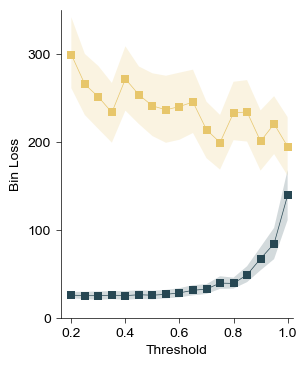

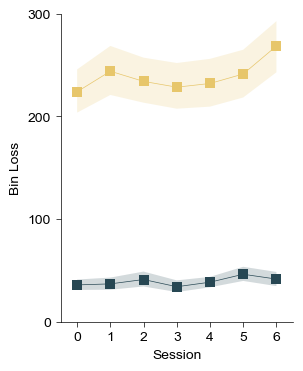

In [5]:
if exists(join(figdata, f"{code_id} [Retrieval Moment].pkl")) == False:
    RetrievData = {
        'MiceID': [],
        'Route': [],
        'Session': [],
        'Bin Loss': [],
        'Threshold': [],
        'Type': []
    }
    minus_bin = np.array([0, 0, 0, 0, 2, 3, 4])
    
    for thre in tqdm(np.linspace(0.2, 1, 17)):
        for mouse in [10212, 10224, 10227, 10232]:
            prop_r0 = hidden_state_proportion(mouse, 0)
            mean_behav = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1)
            mean_behav_whole = np.ones(144)
            mean_behav_whole[CP_DSP[0]-1] = mean_behav
            
            corr_r0 = get_session_wise_neural_retrieval(mouse, 0)
            mean_neuronal = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1)
            mean_neuronal_whole = np.ones(144)
            mean_neuronal_whole[CP_DSP[0]-1] = mean_neuronal
            
            for r in [1, 2, 4, 5, 6]:
                prop = hidden_state_proportion(mouse, r)
                corr = get_session_wise_neural_retrieval(mouse, r)
                
                for s in range(prop.shape[1]):
                    if r == 6 and session_convertor[mouse][s] >= 0:
                        continue
                    
                    behav_idx = np.where(
                        prop[CP_DSP[r]-1, s] - mean_behav_whole[CP_DSP[r]-1] * thre >= 0
                    )[0]
                    
                    neur_idx = np.where(
                        corr[CP_DSP[r]-1, s] - mean_neuronal_whole[CP_DSP[r]-1] * thre >= 0
                    )[0]
                    
                    if behav_idx.shape[0] < 1 or neur_idx.shape[0] < 1:
                        continue
                    
                    RetrievData['Threshold'].append(np.repeat(thre, 2))
                    RetrievData['MiceID'].append(np.repeat(mouse, 2))
                    RetrievData['Route'].append(np.repeat(r, 2))
                    RetrievData['Session'].append(np.repeat(s, 2))
                    RetrievData['Bin Loss'].append([
                        np.abs(behav_idx[0] - neur_idx[0]),
                        np.abs(np.random.randint(0, CP_DSP[r].shape[0], 1)[0] - neur_idx[0])
                    ])
                    RetrievData['Type'].append([
                        "Behavior",
                        "Shuffle",
                    ])
                    
    for k in RetrievData.keys():
        RetrievData[k] = np.concatenate(RetrievData[k])
                    
    with open(join(figdata, f"{code_id} [Retrieval Moment].pkl"), 'wb') as f:
        pickle.dump(RetrievData, f)
        
    RetrievDataD = pd.DataFrame(RetrievData)
    RetrievDataD.to_excel(join(figdata, f"{code_id} [Retrieval Moment].xlsx"), index=False)
    print(len(RetrievDataD))
else:
    with open(join(figdata, f"{code_id} [Retrieval Moment].pkl"), 'rb') as f:
        RetrievData = pickle.load(f)
        
fig = plt.figure(figsize=(3, 4))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
RetrievData['Bin Loss'] *= 8
sns.lineplot(
    x='Threshold',
    y='Bin Loss',
    hue='Type',
    data=RetrievData,
    ax=ax,
    err_kws={'edgecolor': None},
    palette=['#274753', '#e7c66b'],
    marker='s',
    markeredgewidth=0,
    markersize=6,
    #capsize=0.3,
    #err_kws={'linewidth': 0.5, 'color': k},
    #gap=0.2,
    legend=False,
    linewidth=0.5
)
ax.set_ylim(0, 350)
ax.set_yticks(np.linspace(0, 300, 4))
ax.set_xlim(0.16, 1.02)
ax.set_xticks(np.linspace(0.2, 1, 5))
plt.savefig(join(loc, "Loss vs Threshold.png"), dpi=600)
plt.savefig(join(loc, "Loss vs Threshold.svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(3, 4))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Session',
    y='Bin Loss',
    hue='Type',
    data=RetrievData,
    ax=ax,
    err_kws={'edgecolor': None},
    palette=['#274753', '#e7c66b'],
    marker='s',
    markeredgewidth=0,
    markersize=7,
    linewidth=0.5,
    #capsize=0.3,
    #err_kws={'linewidth': 0.5, 'color': k},
    #gap=0.2,
    legend=False
)
ax.set_ylim(0, 300)
ax.set_yticks(np.linspace(0, 300, 4))
ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.linspace(0, 6, 7))
plt.savefig(join(loc, "Loss vs Session.png"), dpi=600)
plt.savefig(join(loc, "Loss vs Session.svg"), dpi=600)
plt.show()

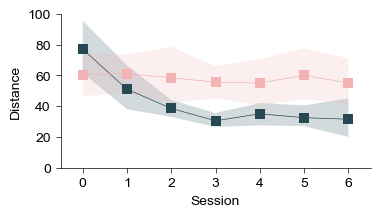

S1: TtestResult(statistic=1.66350142715194, pvalue=0.11695865705950757, df=15)
S2: TtestResult(statistic=-1.4011961980180772, pvalue=0.18150493322200048, df=15)
S3: TtestResult(statistic=-1.9034674690672024, pvalue=0.07634768988570521, df=15)
S4: TtestResult(statistic=-3.9828311742322886, pvalue=0.0012005270004906152, df=15)
S5: TtestResult(statistic=-2.4112141108520606, pvalue=0.029177960109905, df=15)
S6: TtestResult(statistic=-2.7465689319140725, pvalue=0.014989303770843374, df=15)
S7: TtestResult(statistic=-3.118583815325171, pvalue=0.00704460416515834, df=15)
Cross Day
  Behavior: F_onewayResult(statistic=9.001210653753025, pvalue=6.242474631004092e-08)
  Neuronal: F_onewayResult(statistic=0.1173627890921643, pvalue=0.9941593001763696)


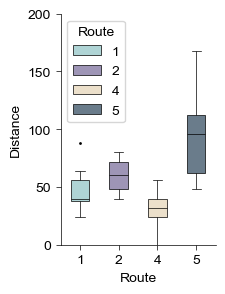

ANOVA F_onewayResult(statistic=50.9820104150229, pvalue=1.3168921047259155e-20)
Route 1 Pre: TtestResult(statistic=1.4682961336602616, pvalue=0.18547084334723943, df=7)
Route 2 Pre: TtestResult(statistic=0.6934810960180178, pvalue=0.5103561842633746, df=7)
Route 4 Pre: TtestResult(statistic=1.1006990785580142, pvalue=0.30743189813032284, df=7)
Route 5 Pre: TtestResult(statistic=-1.4883513944689681, pvalue=0.18026237269037185, df=7)


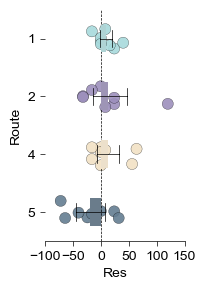

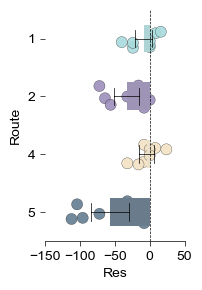

Route 1 Post: TtestResult(statistic=-1.1832159566199232, pvalue=0.27534554870873024, df=7)
Route 2 Post: TtestResult(statistic=-3.390831396068092, pvalue=0.011586295276563545, df=7)
Route 4 Post: TtestResult(statistic=-0.6831300510639732, pvalue=0.5164895523012263, df=7)
Route 5 Post: TtestResult(statistic=-3.6716927704847357, pvalue=0.007946438347907071, df=7)


In [10]:
if exists(join(figdata, f"{code_id} [Distance].pkl")) == False:
    DistanceData = {
        'MiceID': [],
        'Route': [],
        'Session': [],
        'Distance': [],
        'Type': []
    }
    
    thre = 0.5
    minus_bin = np.array([0, 0, 0, 0, 2, 3, 4])
    
    for mouse in [10212, 10224, 10227, 10232]:
        prop_r0 = hidden_state_proportion(mouse, 0)
        mean_behav = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1)
        mean_behav_whole = np.ones(144)
        mean_behav_whole[CP_DSP[0]-1] = mean_behav
        
        corr_r0 = get_session_wise_neural_retrieval(mouse, 0)
        mean_neuronal = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1)
        mean_neuronal_whole = np.ones(144)
        mean_neuronal_whole[CP_DSP[0]-1] = mean_neuronal
        
        for r in [1, 2, 4, 5]:
            prop = hidden_state_proportion(mouse, r)
            corr = get_session_wise_neural_retrieval(mouse, r)
            
            for s in range(prop.shape[1]):
                if r == 6 and session_convertor[mouse][s] >= 0:
                    continue
                
                behav_idx = np.where(
                    prop[CP_DSP[r]-1, s] - mean_behav_whole[CP_DSP[r]-1] * thre >= 0
                )[0]
                
                neur_idx = np.where(
                    corr[CP_DSP[r]-1, s] - mean_neuronal_whole[CP_DSP[r]-1] * thre >= 0
                )[0]
                
                if behav_idx.shape[0] < 1 or neur_idx.shape[0] < 1:
                    continue
                
                DistanceData['MiceID'].append(np.repeat(mouse, 2))
                DistanceData['Route'].append(np.repeat(r, 2))
                DistanceData['Session'].append(np.repeat(s, 2))
                DistanceData['Distance'].append([
                    behav_idx[0] - minus_bin[r],
                    neur_idx[0] - minus_bin[r]
                ])
                DistanceData['Type'].append([
                    "Behavior",
                    "Neuronal",
                ])
    for k in DistanceData.keys():
        DistanceData[k] = np.concatenate(DistanceData[k])
        
    with open(join(figdata, f"{code_id} [Distance].pkl"), 'wb') as f:
        pickle.dump(DistanceData, f)
        
    DistanceD = pd.DataFrame(DistanceData)
    DistanceD.to_excel(join(figdata, f"{code_id} [Distance].xlsx"), index=False)
    print(len(DistanceD))
else:
    with open(join(figdata, f"{code_id} [Distance].pkl"), 'rb') as f:
        DistanceData = pickle.load(f)




fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
DistanceData['Distance'] *= 8
sns.lineplot(
    x='Session',
    y='Distance',
    hue='Type',
    data=DistanceData,
    ax=ax,
    err_kws={'edgecolor': None},
    palette=['#274753', '#f3b2b4'], #[DSPPalette[i] for i in [1, 2, 4, 5]], #
    marker='s',
    markeredgewidth=0,
    markersize=7,
    linewidth=0.5,
    #capsize=0.3,
    #err_kws={'linewidth': 0.5, 'color': k},
    #gap=0.2,
    legend=False
)
ax.set_ylim(0, 100)
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.linspace(0, 6, 7))
plt.savefig(join(loc, "Learning Effect.png"), dpi=600)
plt.savefig(join(loc, "Learning Effect.svg"), dpi=600)
plt.show()

res_behav = [
    DistanceData['Distance'][(DistanceData['Type'] == 'Behavior') & (DistanceData['Session'] == s)]
    for s in range(7)
]
res_neuronal = [
    DistanceData['Distance'][(DistanceData['Type'] == 'Neuronal') & (DistanceData['Session'] == s)]
    for s in range(7)
]
for s in range(7):
    print(f"S{s+1}: {ttest_rel(res_behav[s], res_neuronal[s])}")
    
print("Cross Day")
print(f"  Behavior: {f_oneway(*res_behav)}")
print(f"  Neuronal: {f_oneway(*res_neuronal)}")





SubData = SubDict(
    DistanceData,
    DistanceData.keys(),
    np.where((DistanceData['Type'] == 'Neuronal'))[0]
)
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.boxplot(
    x='Route',
    y='Distance',
    hue='Route',
    data=SubData,
    ax=ax,
    palette=[DSPPalette[rt] for rt in [1, 2, 4, 5]],
    orient='v',
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    gap=0.4
)
ax.set_ylim(0, 200)
ax.set_yticks(np.linspace(0, 200, 5))
plt.savefig(join(loc, "Neuronal Distance by Route.png"), dpi=600)
plt.savefig(join(loc, "Neuronal Distance by Route.svg"), dpi=600)
plt.show()
res = [SubData['Distance'][SubData['Route'] == r] for r in [1, 2, 4, 5]]
print(f"ANOVA {f_oneway(*res)}")







DistanceData['Res'] = cp.deepcopy(DistanceData['Distance'])
DistanceData['Res'][DistanceData['Type'] == 'Behavior'] -= DistanceData['Res'][DistanceData['Type'] == 'Neuronal']
SubData_Pre = SubDict(
    DistanceData,
    DistanceData.keys(),
    np.where((DistanceData['Session'] < 2)&(DistanceData['Type'] == 'Behavior'))[0]
)
SubData_Post = SubDict(
    DistanceData,
    DistanceData.keys(),
    np.where((DistanceData['Session'] >= 5)&(DistanceData['Type'] == 'Behavior'))[0]
)
fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right', 'left'], ifxticks=True, ifyticks=True)
# Horizontal bar plot
ax.axvline(0, color='k', lw=0.5, ls='--')
sns.barplot(
    x='Res',
    y='Route',
    hue='Route',
    data=SubData_Pre,
    ax=ax,
    palette=[DSPPalette[rt] for rt in [1, 2, 4, 5]],
    orient='h',
    capsize=0.3,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    gap=0.4,
    legend=False,
    zorder=2
    #capsize=0.3,
    #err_kws={'linewidth': 0.5, 'color': 'k'},
)
sns.stripplot(
    x='Res',
    y='Route',
    data=SubData_Pre,
    ax=ax,
    hue='Route',
    palette=[DSPPalette[rt] for rt in [1, 2, 4, 5]],
    orient='h',
    size=8,
    linewidth=0.2,
    edgecolor='k',
    jitter=0.2,
    alpha=0.9,
    legend=False,
    zorder=1
)
ax.set_xlim(-100, 150)
ax.set_xticks(np.linspace(-100, 150, 6))
for rt in [1, 2, 4, 5]:
    idx = np.where(SubData_Pre['Route'] == rt)[0]
    print(f"Route {rt} Pre: {ttest_1samp(SubData_Pre['Res'][idx], 0)}")
plt.savefig(join(loc, "Early Stage Differences.png"), dpi=600)
plt.savefig(join(loc, "Early Stage Differences.svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right', 'left'], ifxticks=True, ifyticks=True)
# Horizontal bar plot
ax.axvline(0, color='k', lw=0.5, ls='--')
sns.barplot(
    x='Res',
    y='Route',
    hue='Route',
    data=SubData_Post,
    ax=ax,
    palette=[DSPPalette[rt] for rt in [1, 2, 4, 5]],
    orient='h',
    capsize=0.3,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    gap=0.4,
    legend=False,
    zorder=2
    #capsize=0.3,
    #err_kws={'linewidth': 0.5, 'color': 'k'},
)
sns.stripplot(
    x='Res',
    y='Route',
    data=SubData_Post,
    hue='Route',
    ax=ax,
    palette=[DSPPalette[rt] for rt in [1, 2, 4, 5]],
    orient='h',
    size=8,
    linewidth=0.2,
    edgecolor='k',
    jitter=0.2,
    alpha=0.9,
    legend=False,
    zorder=1
)
ax.set_xlim(-150, 50)
ax.set_xticks(np.linspace(-150, 50, 5))
plt.savefig(join(loc, "Later Stage Differences.png"), dpi=600)
plt.savefig(join(loc, "Later Stage Differences.svg"), dpi=600)
plt.show()
for rt in [1, 2, 4, 5]:
    idx = np.where(SubData_Post['Route'] == rt)[0]
    print(f"Route {rt} Post: {ttest_1samp(SubData_Post['Res'][idx], 0)}")
    
    
    
    


# Cross-Day Stability

        E:\Data\FinalResults\Dsp\0860 - 2 - Retrieval on Session-Basis\Stability is already existed!


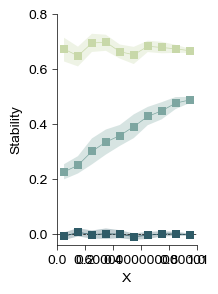

Cross-Day: 5.948061500298744e-22
R1-Ctrl: 0.643562270657769
Shuffle: 0.6058151327462901


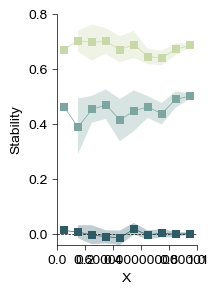

Cross-Day: 0.9485581977492639
R1-Ctrl: 0.995765227207433
Shuffle: 0.7831204724218145


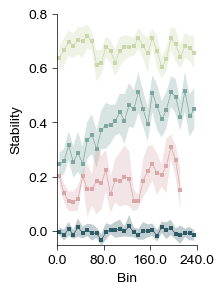

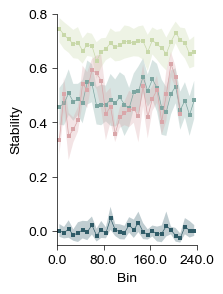

In [7]:
dir_stability = join(loc, "Stability")
mkdir(dir_stability)

if exists(join(figdata, f"{code_id} [Cross-Day Stability vs Behavior].pkl")) == False:
    Stability = { 
        'MiceID': [],
        'Session': [],
        'Bin': [],
        'Route': [],
        'Session': [],
        'Stability': [],
        'Pre-Behavior': [],
        'Post-Behavior': [],
        'Type': []
    }
    
    nodes_convertor = np.array([0, 1, 2, 3, 6, 7, 8])
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        with open(f_CellReg_dsp['cellreg_folder'][m+1], 'rb') as f:
            index_map = pickle.load(f).astype(np.int64)
        
        if mouse != 10232:
            index_map = index_map[1:, :]
            
        is_cell = np.where(index_map > 0, 1, 0)
        n_cells = np.sum(is_cell, axis=0)
        
        file_idx = np.where(f2['MiceID'] == mouse)[0]

        prop_r0 = hidden_state_proportion(mouse, 0)
        mean_behav = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1)
        mean_behav_whole = np.ones(144)
        mean_behav_whole[CP_DSP[0]-1] = mean_behav
        corr_r0 = get_session_wise_neural_retrieval(mouse, 0)
        mean_neuronal = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1)
        mean_neuronal_whole = np.ones(144)
        mean_neuronal_whole[CP_DSP[0]-1] = mean_neuronal
        
        for s in tqdm(range(6)):
            cell_idx = np.where(
                (is_cell[s, :] == 1) &
                (is_cell[s+1, :] == 1)
            )[0]
            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace1 = pickle.load(f)
            
            with open(f2['Trace File'][file_idx[s+1]], 'rb') as f:
                trace2 = pickle.load(f)
            
            r0_avg_1 = np.mean(np.stack([
                trace1[f'node {n}']['old_map_clear'][index_map[s, cell_idx]-1, :] for n in [0, 4, 5, 9]
            ], axis=2), axis=2)
        
            r0_avg_2 = np.mean(np.stack([
                trace2[f'node {n}']['old_map_clear'][index_map[s+1, cell_idx]-1, :] for n in [0, 4, 5, 9]
            ], axis=2), axis=2)
            
            for r in [1, 2, 4, 5]:
                prop_rt = hidden_state_proportion(mouse, r)
                corr_rt = get_session_wise_neural_retrieval(mouse, r)
                
                bins = CP_DSP[r][minus_bin[r]:]-1
                corrs = np.zeros((bins.shape[0], 4))
                rt_map_1 = trace1[f'node {nodes_convertor[r]}']['old_map_clear'][index_map[s, cell_idx]-1, :]
                rt_map_2 = trace2[f'node {nodes_convertor[r]}']['old_map_clear'][index_map[s+1, cell_idx]-1, :]
                
                rt_map4_1 = trace1[f'node 3']['old_map_clear'][index_map[s, cell_idx]-1, :]
                rt_map4_2 = trace2[f'node 3']['old_map_clear'][index_map[s+1, cell_idx]-1, :]
                
                for i, b in enumerate(bins):
                    corrs[i, 0] = np.corrcoef(
                        rt_map_1[:, b], rt_map_2[:, b]
                    )[0, 1]
                    corrs[i, 1] = np.corrcoef(
                        r0_avg_1[:, b], r0_avg_2[:, b]
                    )[0, 1]
                    if i < CP_DSP[3].shape[0]:
                        corrs[i, 2] = np.corrcoef(
                            rt_map4_1[:, CP_DSP[3][i]-1], rt_map4_2[:, CP_DSP[3][i]-1]
                        )[0, 1]
                    else:
                        corrs[i, 2] = np.nan
                        
                    corrs[i, 3] = np.corrcoef(
                        rt_map_1[:, b], rt_map_1[:, b][np.random.permutation(rt_map_1.shape[0])]
                    )[0, 1]
                
                    Stability['MiceID'].append(np.repeat(mouse, 4))
                    Stability['Route'].append(np.repeat(r, 4))
                    Stability['Session'].append(np.repeat(s, 4))
                    Stability['Stability'].append(corrs[i, :])
                    Stability['Bin'].append(np.repeat(i, 4))
                    Stability['Pre-Behavior'].append(np.repeat(prop_rt[b, s], 4) / mean_behav_whole[b])
                    Stability['Post-Behavior'].append(np.repeat(prop_rt[b, s+1], 4) / mean_behav_whole[b])
                    Stability['Type'].append(["Cross-Day", "R1-Ctrl", 'R4-Ctrl', "Shuffle"])
    
    for k in Stability.keys():
        Stability[k] = np.concatenate(Stability[k])
    
    with open(join(figdata, f"{code_id} [Cross-Day Stability vs Behavior].pkl"), 'wb') as f:
        pickle.dump(Stability, f)

    StabilityD = pd.DataFrame(Stability)
    StabilityD.to_excel(join(figdata, f"{code_id} [Cross-Day Stability vs Behavior].xlsx"), index=False)
    print(len(StabilityD))
else:
    with open(join(figdata, f"{code_id} [Cross-Day Stability vs Behavior].pkl"), 'rb') as f:
        Stability = pickle.load(f)

Stability['X'] = (Stability['Pre-Behavior'] + Stability['Post-Behavior']) / 2
Stability['X'] = np.clip(Stability['Pre-Behavior'] // 0.1, 0, 9).astype(np.int64)
"""
for s in range(6):
    for r in [1, 2, 4, 5]:
        SubData = SubDict(
            Stability,
            Stability.keys(),
            np.where(
                (Stability['Session'] == s) &
                (Stability['Route'] == r) &
                (Stability['Bin'] < 20) &
                (Stability['Type'] != 'R4-Ctrl')
            )[0]
        )
        fig = plt.figure(figsize=(2, 3))
        ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
        sns.lineplot(
                x='Bin',
                y='Stability',
                hue='Type',
                data=SubData,
                palette=['#7da6a1', '#c8d8a9', '#2f5b67'],
                ax=ax,
                err_kws={'edgecolor': None, 'alpha':0.3},
                linewidth=0.5,
                marker='s',
                markersize=4,
                markeredgewidth=0,
        )
        ax.set_xticks(np.linspace(-0.5, 19.5, 5), np.linspace(0, 160, 5))
        p = np.zeros(3)
        for i, t in enumerate(['Cross-Day', 'R1-Ctrl', 'Shuffle']):
            idx0 = np.where(
                (SubData['Type'] == t) &
                (np.isnan(SubData['Stability']) == False)
            )[0]
            p[i] = linregress(SubData['Bin'][idx0], SubData['Stability'][idx0]).pvalue
        ax.set_xlim(-0.5, 19.5)
        ax.set_title(f"{p[0]}\n{p[1]}\n{p[2]}", fontsize=8)
        plt.savefig(join(dir_stability, f"S{s+1} R{r+1}.png"), dpi=600)
        plt.savefig(join(dir_stability, f"S{s+1} R{r+1}.svg"), dpi=600)
        plt.close()
"""    

SubData = SubDict(
    Stability,
    Stability.keys(),
    np.where(
        (Stability['Type'] != 'R4-Ctrl') & 
        (Stability['Session'] == 0)
    )[0]
)
SubData['hue'] = []
for i in range(SubData['Stability'].shape[0]):
    if SubData['Type'][i] == 'Cross-Day':
        SubData['hue'].append(f"R{int(SubData['Route'][i])+1}")
    elif SubData['Type'][i] == 'R1-Ctrl':
        SubData['hue'].append('R1-Ctrl')
    elif SubData['Type'][i] == 'R4-Ctrl':
        SubData['hue'].append('R4-Ctrl')
    else:
        SubData['hue'].append('Shuffle')
SubData['hue'] = np.array(SubData['hue'])


fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', lw=0.5, ls='--')
sns.lineplot(
    x='X',
    y='Stability',
    hue='Type',
    data=SubData,
    palette=['#7da6a1', '#c8d8a9', '#2f5b67'], #['#c8d8a9', 'k', DSPPalette[1], DSPPalette[2], DSPPalette[4], DSPPalette[5]],
    #hue_order=['R1-Ctrl', 'Shuffle', 'R2', 'R3', 'R5', 'R6'],
    ax=ax,
    err_kws={'edgecolor': None, 'alpha':0.3},
    linewidth=0.5,
    marker='s',
    markersize=6,
    markeredgewidth=0,
    legend=False
)
ax.set_ylim(-0.04, 0.8)
ax.set_yticks(np.linspace(-0, 0.8, 5))
ax.set_xticks(np.linspace(-0.5, 9.5, 6), np.linspace(0, 1, 6))
ax.set_xlim(-0.5, 9.5)
plt.savefig(join(loc, "Stability S0.png"), dpi=600)
plt.savefig(join(loc, "Stability S0.svg"), dpi=600)
plt.show()
p = np.zeros(3)
for i, t in enumerate(['Cross-Day', 'R1-Ctrl', 'Shuffle']):
    idx0 = np.where(
        (SubData['Type'] == t) &
        (np.isnan(SubData['Stability']) == False)
    )[0]
    p[i] = linregress(SubData['Bin'][idx0], SubData['Stability'][idx0], alternative='greater').pvalue
    print(f"{t}: {p[i]}")


SubData = SubDict(
    Stability,
    Stability.keys(),
    np.where(
        (Stability['Type'] != 'R4-Ctrl') & 
        (Stability['Session'] == 5)
    )[0]
)
fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', lw=0.5, ls='--')
sns.lineplot(
    x='X',
    y='Stability',
    hue='Type',
    data=SubData,
    palette=['#7da6a1', '#c8d8a9', '#2f5b67'], #['#c8d8a9', 'k', DSPPalette[1], DSPPalette[2], DSPPalette[4], DSPPalette[5]],
    #hue_order=['R1-Ctrl', 'Shuffle', 'R2', 'R3', 'R5', 'R6'],
    ax=ax,
    err_kws={'edgecolor': None, 'alpha':0.3},
    linewidth=0.5,
    marker='s',
    markersize=6,
    markeredgewidth=0,
    legend=False
)
ax.set_ylim(-0.04, 0.8)
ax.set_yticks(np.linspace(-0, 0.8, 5))
ax.set_xticks(np.linspace(-0.5, 9.5, 6), np.linspace(0, 1, 6))
ax.set_xlim(-0.5, 9.5)
plt.savefig(join(loc, "Stability S6.png"), dpi=600)
plt.savefig(join(loc, "Stability S6.svg"), dpi=600)
plt.show()
p = np.zeros(3)
for i, t in enumerate(['Cross-Day', 'R1-Ctrl', 'Shuffle']):
    idx0 = np.where(
        (SubData['Type'] == t) &
        (np.isnan(SubData['Stability']) == False)
    )[0]
    p[i] = linregress(SubData['Bin'][idx0], SubData['Stability'][idx0], alternative='greater').pvalue
    print(f"{t}: {p[i]}")
    

SubData = SubDict(
    Stability,
    Stability.keys(),
    np.where(
        #(Stability['Type'] != 'R4-Ctrl') & 
        (Stability['Session'] == 0) & 
        (Stability['Bin'] < 30)
    )[0]
)
"""
p0 = np.zeros(30)
p1 = np.zeros(30)
for b in range(30):
    idx_data = np.where(
        (SubData['Bin'] == b) &
        (SubData['Type'] == 'Cross-Day')
    )[0]
    idx_ctrl = np.where(
        (SubData['Bin'] == b) &
        (SubData['Type'] == 'R1-Ctrl')
    )[0]
    idx_ctrl_r4 = np.where(
        (np.isnan(SubData['Stability']) == False) &
        (np.isnan())
        (SubData['Type'] == 'R4-Ctrl')
    )[0]
    common_idx = np.where(
        (np.isnan(SubData['Stability'][idx_data]) == False) &
        (np.isnan(SubData['Stability'][idx_ctrl]) == False)
    )
    idx_data, idx_ctrl = idx_data[common_idx], idx_ctrl[common_idx]
    
    p0[b] = ttest_rel(
        SubData['Stability'][idx_data],
        SubData['Stability'][idx_ctrl]
    ).pvalue
    p1[b] = ttest_ind(
        SubData['Stability'][idx_data],
        SubData['Stability'][idx_ctrl_r4]
    ).pvalue
p0 = np.clip(p0, 1e-10, 1)
p1 = np.clip(p1, 1e-10, 1)
"""    
fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Bin',
    y='Stability',
    hue='Type',
    data=SubData,
    palette=['#7da6a1', '#c8d8a9', DSPPalette[3], '#2f5b67'],
    ax=ax,
    linewidth=0.5,
    err_kws={'edgecolor': None, 'alpha':0.3},
    marker='s',
    markersize=3,
    markeredgewidth=0,
    legend=False
)
ax.set_ylim(-0.05, 0.8)
ax.set_yticks(np.linspace(0, 0.8, 5))
ax.set_xlim(-0.5, 29.5)
ax.set_xticks(np.linspace(-0.5, 29.5, 4), np.linspace(0, 240, 4))
plt.savefig(join(loc, "Stability S0 by Bin.png"), dpi=600)
plt.savefig(join(loc, "Stability S0 by Bin.svg"), dpi=600)
plt.show()



SubData = SubDict(
    Stability,
    Stability.keys(),
    np.where(
        #(Stability['Type'] != 'R4-Ctrl') & 
        (Stability['Session'] == 5) & 
        (Stability['Bin'] < 30)
    )[0]
)
fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Bin',
    y='Stability',
    hue='Type',
    data=SubData,
    palette=['#7da6a1', '#c8d8a9', DSPPalette[3], '#2f5b67'],
    ax=ax,
    linewidth=0.5,
    err_kws={'edgecolor': None, 'alpha':0.3},
    marker='s',
    markersize=3,
    markeredgewidth=0,
    legend=False
)
ax.set_ylim(-0.05, 0.8)
ax.set_yticks(np.linspace(0, 0.8, 5))
ax.set_xlim(-0.5, 29.5)
ax.set_xticks(np.linspace(-0.5, 29.5, 4), np.linspace(0, 240, 4))
plt.savefig(join(loc, "Stability S6 by Bin.png"), dpi=600)
plt.savefig(join(loc, "Stability S6 by Bin.svg"), dpi=600)
plt.show()

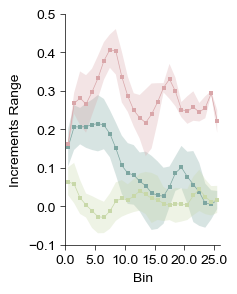

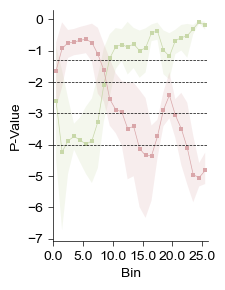

In [9]:
if exists(join(figdata, f"{code_id} [Stability Accumulated Increments].xlsx")) == False:
    AccumulatedIncrements = {
        'MiceID': [],
        'Route': [],
        'Bin': [],
        'Increments Range': [],
        'Bin': [],
        'Hue': [],
        'Type': []
    }
    gkernel = gaussian_kernel(np.arange(-1, 2), 1)
    
    for mouse in [10212, 10224, 10227, 10232]:
        for r in [1, 2, 4, 5]:
            r4_range = np.vstack([
                Stability['Stability'][
                    (Stability['Type'] == 'R4-Ctrl') &
                    (Stability['Session'] == n) &
                    (Stability['MiceID'] == mouse) &
                    (Stability['Route'] == r) & 
                    (Stability['Bin'] < 26)
                ] for n in range(6)
            ])
            r4_range = r4_range[-1, :] - r4_range[0, :]
            
            r1_range = np.vstack([
                Stability['Stability'][
                    (Stability['Type'] == 'R1-Ctrl') &
                    (Stability['Session'] == n) &
                    (Stability['MiceID'] == mouse) &
                    (Stability['Route'] == r) & 
                    (Stability['Bin'] < 40)
                ] for n in range(6)
            ])
            r1_range = r1_range[-1, :] - r1_range[0, :]
            
            stability_range = np.zeros((26, 4))
            for b in range(26):
                stability_range_all = np.vstack([
                    Stability['Stability'][
                        #(Stability['Type'] != 'R4-Ctrl') &
                        #(Stability['Type'] != 'R1-Ctrl') &
                        (Stability['Session'] == n) &
                        (Stability['MiceID'] == mouse) &
                        (Stability['Route'] == r) &
                        (Stability['Bin'] == b)
                    ] for n in range(6)
                ])
                stability_range[b, :] = stability_range_all[-1, :] - stability_range_all[0, :]
            
            for j in range(4):
                stability_range[np.isnan(stability_range[:, j]) == False, j] = np.convolve(stability_range[np.isnan(stability_range[:, j]) == False, j], gkernel, mode='same')
                
            r4_range[1:-1] = np.convolve(r4_range[1:-1], gkernel, mode='same')
            r1_range[1:-1] = np.convolve(r1_range[1:-1], gkernel, mode='same')
            #stability_range = (stability_range - np.nanmean(stability_range[:, 1:2])) / (np.nanmean(r4_range) - np.nanmean(stability_range[:, 1:2]))
            #r4_range = (r4_range - np.nanmean(stability_range[:, 1:2])) / (np.nanmean(r4_range) - np.nanmean(stability_range[:, 1:2]))
            #r4_range /= np.nanmean(r4_range)
            #r4_range[np.isnan(r4_range) == False] = np.convolve(r4_range[np.isnan(r4_range) == False], gkernel, mode='same')
            
            for b in range(26):   
                AccumulatedIncrements['MiceID'].append(np.repeat(mouse, 4))
                AccumulatedIncrements['Route'].append(np.repeat(r, 4))
                AccumulatedIncrements['Bin'].append(np.repeat(b, 4))
                AccumulatedIncrements['Increments Range'].append(np.concatenate([
                    stability_range[b, :]#, r4_range, r1_range
                ]))
                AccumulatedIncrements['Type'].append([
                    "Cross-Day",
                    "R1-Ctrl",
                    "R4-Ctrl",
                    "Shuffle"
                ])#+['R4-Ctrl'] * r4_range.shape[0] + ["R1-Ctrl"] * r1_range.shape[0])
                AccumulatedIncrements['Hue'].append([
                    f"R{r}",
                    "R1-Ctrl",
                    "R4-Ctrl",
                    "Shuffle"
                ])#+['R4-Ctrl'] * r4_range.shape[0] + ["R1-Ctrl"] * r1_range.shape[0])
                
    for k in AccumulatedIncrements.keys():
        AccumulatedIncrements[k] = np.concatenate(AccumulatedIncrements[k])
        
    with open(join(figdata, f"{code_id} [Stability Accumulated Increments].pkl"), 'wb') as f:
        pickle.dump(AccumulatedIncrements, f)
        
    AccumulatedIncrementsD = pd.DataFrame(AccumulatedIncrements)
    AccumulatedIncrementsD.to_excel(join(figdata, f"{code_id} [Stability Accumulated Increments].xlsx"), index=False)
    print(len(AccumulatedIncrementsD))
else:
    with open(join(figdata, f"{code_id} [Stability Accumulated Increments].pkl"), 'rb') as f:
        AccumulatedIncrements = pickle.load(f)



SubData = SubDict(
        AccumulatedIncrements,
        AccumulatedIncrements.keys(),
        np.where((AccumulatedIncrements['Type'] != 'Shuffle') & (AccumulatedIncrements['Bin'] < 26))[0]
)
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
        x='Bin',
        y='Increments Range',
        hue='Type',
        data=SubData,
        ax=ax,
        err_kws={'edgecolor': None, 'alpha':0.3},
        palette=['#7da6a1', '#c8d8a9', DSPPalette[3]],
        #palette=[DSPPalette[1], DSPPalette[2], DSPPalette[4], DSPPalette[5], '#c8d8a9', DSPPalette[3]],
        #hue_order=['R1', 'R2', 'R5', 'R6', 'R1-Ctrl', 'R4-Ctrl'],
        hue_order=['Cross-Day', 'R1-Ctrl', 'R4-Ctrl'],
        marker='s',
        markersize=3,
        markeredgewidth=0,
        linewidth=0.5,
        legend=False
)
ax.set_ylim(-0.1, 0.5)
ax.set_yticks(np.linspace(-0.1, 0.5, 7))
ax.set_xlim(-0.5, 25.5)
ax.set_xticks(np.linspace(-0.5, 24.5, 6), np.linspace(0, 25, 6))
plt.savefig(join(loc, "Cumulative Increments by Bin.png"), dpi=600)
plt.savefig(join(loc, "Cumulative Increments by Bin.svg"), dpi=600)
plt.show()

p0 = np.zeros((26, 4))
p1 = np.zeros((26, 4))
for i, rt in enumerate([1, 2, 4, 5]):
    for b in range(26):
        idx0 = np.where((SubData['Type'] == 'Cross-Day')&(SubData['Bin'] == b)&(np.isnan(SubData['Increments Range']) == False)&(SubData['Route']==rt))[0]
        idx1 = np.where((SubData['Type'] == 'R1-Ctrl')&(np.isnan(SubData['Increments Range']) == False)&(SubData['Route']==rt))[0]
        idx2 = np.where((SubData['Type'] == 'R4-Ctrl')&(np.isnan(SubData['Increments Range']) == False)&(SubData['Route']==rt))[0]    

        p0[b, i] = ttest_ind(
            SubData['Increments Range'][idx0],
            SubData['Increments Range'][idx1]
        ).pvalue
        
        p1[b, i] = ttest_ind(
            SubData['Increments Range'][idx0],
            SubData['Increments Range'][idx2]
        ).pvalue

if exists(join(figdata, f"{code_id} [Cumulative Stability P-Values].pkl")) == False:
    CumuStabPValues = {
        "Bin": [],
        "Route": [],
        "P-Value": [],
        "Type": []
    }
    for i, rt in enumerate([1, 2, 4, 5]):
        for b in range(26):
            CumuStabPValues['Bin'].append(b)
            CumuStabPValues['Route'].append(rt)
            CumuStabPValues['P-Value'].append(p0[b, i])
            CumuStabPValues['Type'].append('R1-Ctrl')
            
            CumuStabPValues['Bin'].append(b)
            CumuStabPValues['Route'].append(rt)
            CumuStabPValues['P-Value'].append(p1[b, i])
            CumuStabPValues['Type'].append('R4-Ctrl')
            
    CumuStabPValuesD = pd.DataFrame(CumuStabPValues)
    CumuStabPValuesD.to_excel(join(figdata, f"{code_id} [Cumulative Stability P-Values].xlsx"), index=False)
    with open(join(figdata, f"{code_id} [Cumulative Stability P-Values].pkl"), 'wb') as f:
        pickle.dump(CumuStabPValues, f)
    print(len(CumuStabPValuesD))
else:
    with open(join(figdata, f"{code_id} [Cumulative Stability P-Values].pkl"), 'rb') as f:
        CumuStabPValues = pickle.load(f)
    
CumuStabPValues['P-Value'] = np.log10(CumuStabPValues['P-Value'])
fig = plt.figure(figsize=(2, 3))
ax_twin = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifyticks=True, ifxticks=True)
sns.lineplot(
    x='Bin',
    y='P-Value',
    hue='Type',
    data=CumuStabPValues,
    ax=ax_twin,
    palette=['#c8d8a9', DSPPalette[3]],
    hue_order=['R1-Ctrl', 'R4-Ctrl'],
    linewidth=0.5,
    marker='s',
    markersize=3,
    markeredgewidth=0,
    legend=False,
    err_kws={'edgecolor': None}
)
ax_twin.axhline(np.log10(0.05), color='k', lw=0.5, ls='--')
ax_twin.axhline(-2, color='k', lw=0.5, ls='--')
ax_twin.axhline(-3, color='k', lw=0.5, ls='--')
ax_twin.axhline(-4, color='k', lw=0.5, ls='--')
ax_twin.set_xlim(-0.5, 25.5)
ax_twin.set_xticks(np.linspace(-0.5, 24.5, 6), np.linspace(0, 25, 6))
plt.savefig(join(loc, "Cumulative Stability P-Values by Bin.png"), dpi=600)
plt.savefig(join(loc, "Cumulative Stability P-Values by Bin.svg"), dpi=600)
plt.show()